&#x1f12f; Raquel Pérez & Javier Bejar - APA/GEI/FIB/UPC

In [61]:
# Uncomment to upgrade packages
#!pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade 
# !pip install scikit-optimize --user --quiet
# !pip install apafib --upgrade --user --quiet
# !pip3 install matplotlib --force

In [62]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# APA - Laboratorio - Sesión 3
## Regresión Lineal

In [63]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

## SECCIÓN 1: Los datos

En esta sesión de laboratorio vamos a predecir la esperanza de vida de diferentes países durante diferentes años dados diferentes marcadores socioeconómicos.

Como puede notar, este conjunto de datos tiene un componente temporal (la esperanza de vida en un país un año puede tener una correlación con los años anteriores y posteriores). Normalmente, este componente temporal debe tenerse en cuenta (rompe la suposición de iid, por ejemplo), sin embargo, por simplicidad, lo ignoraremos. El tratamiento del componente temporal está fuera del alcance del curso.


In [64]:
# load data from file
try:
    from apafib import load_medical_costs
    life_expectancy_data = load_medical_costs()
except:
    life_expectancy_data = pd.read_csv('Life_Expectancy_Data.csv')

# remove spaces and symbols to avoid problems with statsmodel GLM
life_expectancy_data.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in life_expectancy_data.columns] 

# change the type of categorical variables into category
categorical_columns = list(life_expectancy_data.dtypes[life_expectancy_data.dtypes == 'O'].index.values)
for column in categorical_columns:
    life_expectancy_data[column] = life_expectancy_data[column].astype('category')

# peak into the data
life_expectancy_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


Siempre es una buena idea hacer una pequeña exploración de los datos. Los datos reales necesitan procesamiento previo y es importante comprender su conjunto de datos para poder tomar buenas decisiones de diseño.

Nuestro conjunto de datos tiene 2938 muestras y 21 variables predictivas. Nuestro objetivo es `life_expectancy`.

Vamos a hacer una visualización rápida de los datos. En esta visualización usamos histogramas para mostrar la distribución de las variables numéricas y diagramas de barras para las categóricas.

Con este tipo de visualizaciones fáciles, podemos ver mucha información relevante sobre nuestros datos, como si tenemos nuestros valores o si alguna variable se ha codificado incorrectamente, o si "parece" lo suficientemente gaussiana.

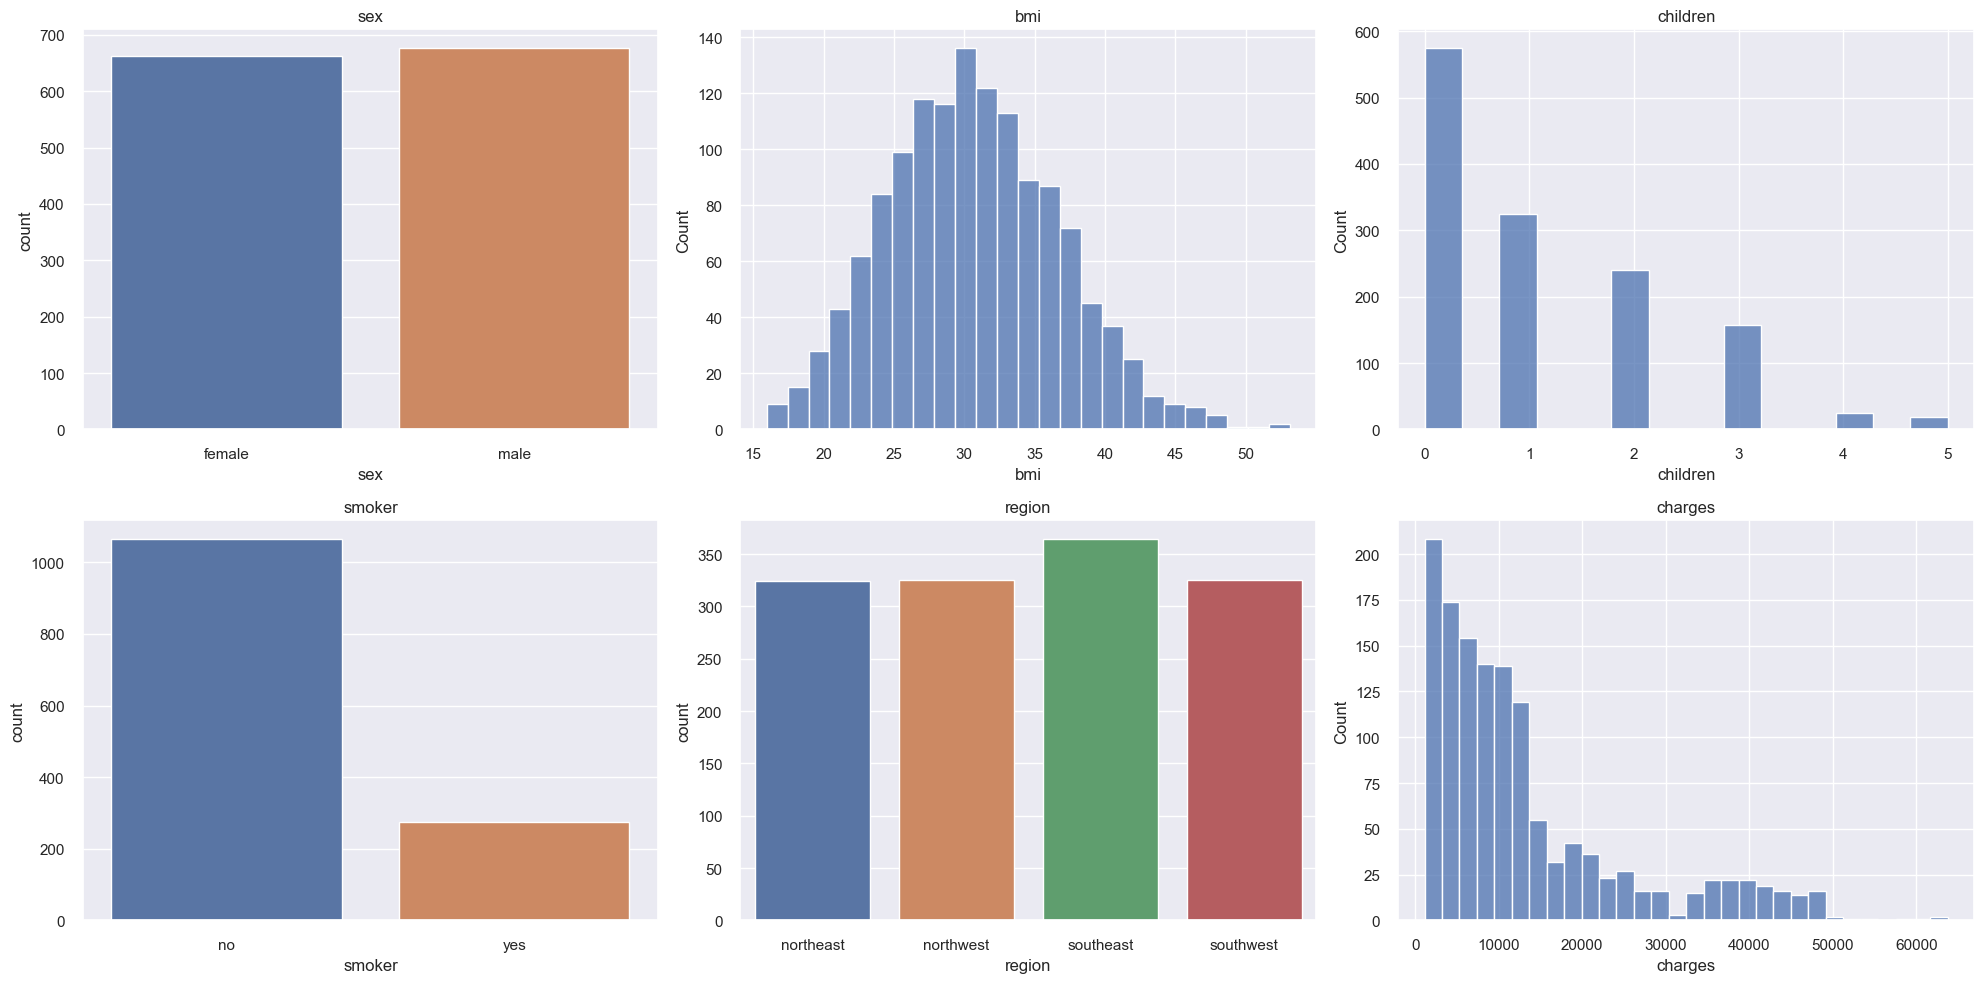

In [73]:
fig, axes = plt.subplots(2,3,figsize=(20,10))

# We will not plot country because it has too many categories.
for i, c in enumerate(life_expectancy_data.columns[1:]):
    ax = axes.reshape(-1)[i]
    if life_expectancy_data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=life_expectancy_data,ax=ax)
    else:
        b = sns.histplot(x=c,data=life_expectancy_data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

Si no podéis representar una variable categórica de manera efectiva porque tiene demasiadas categorías, podéis verificarla con la función `value_counts`.

Otra forma de visualizar cada variable (numérica) es usar la función de histograma de `pandas` en todo el marco de datos

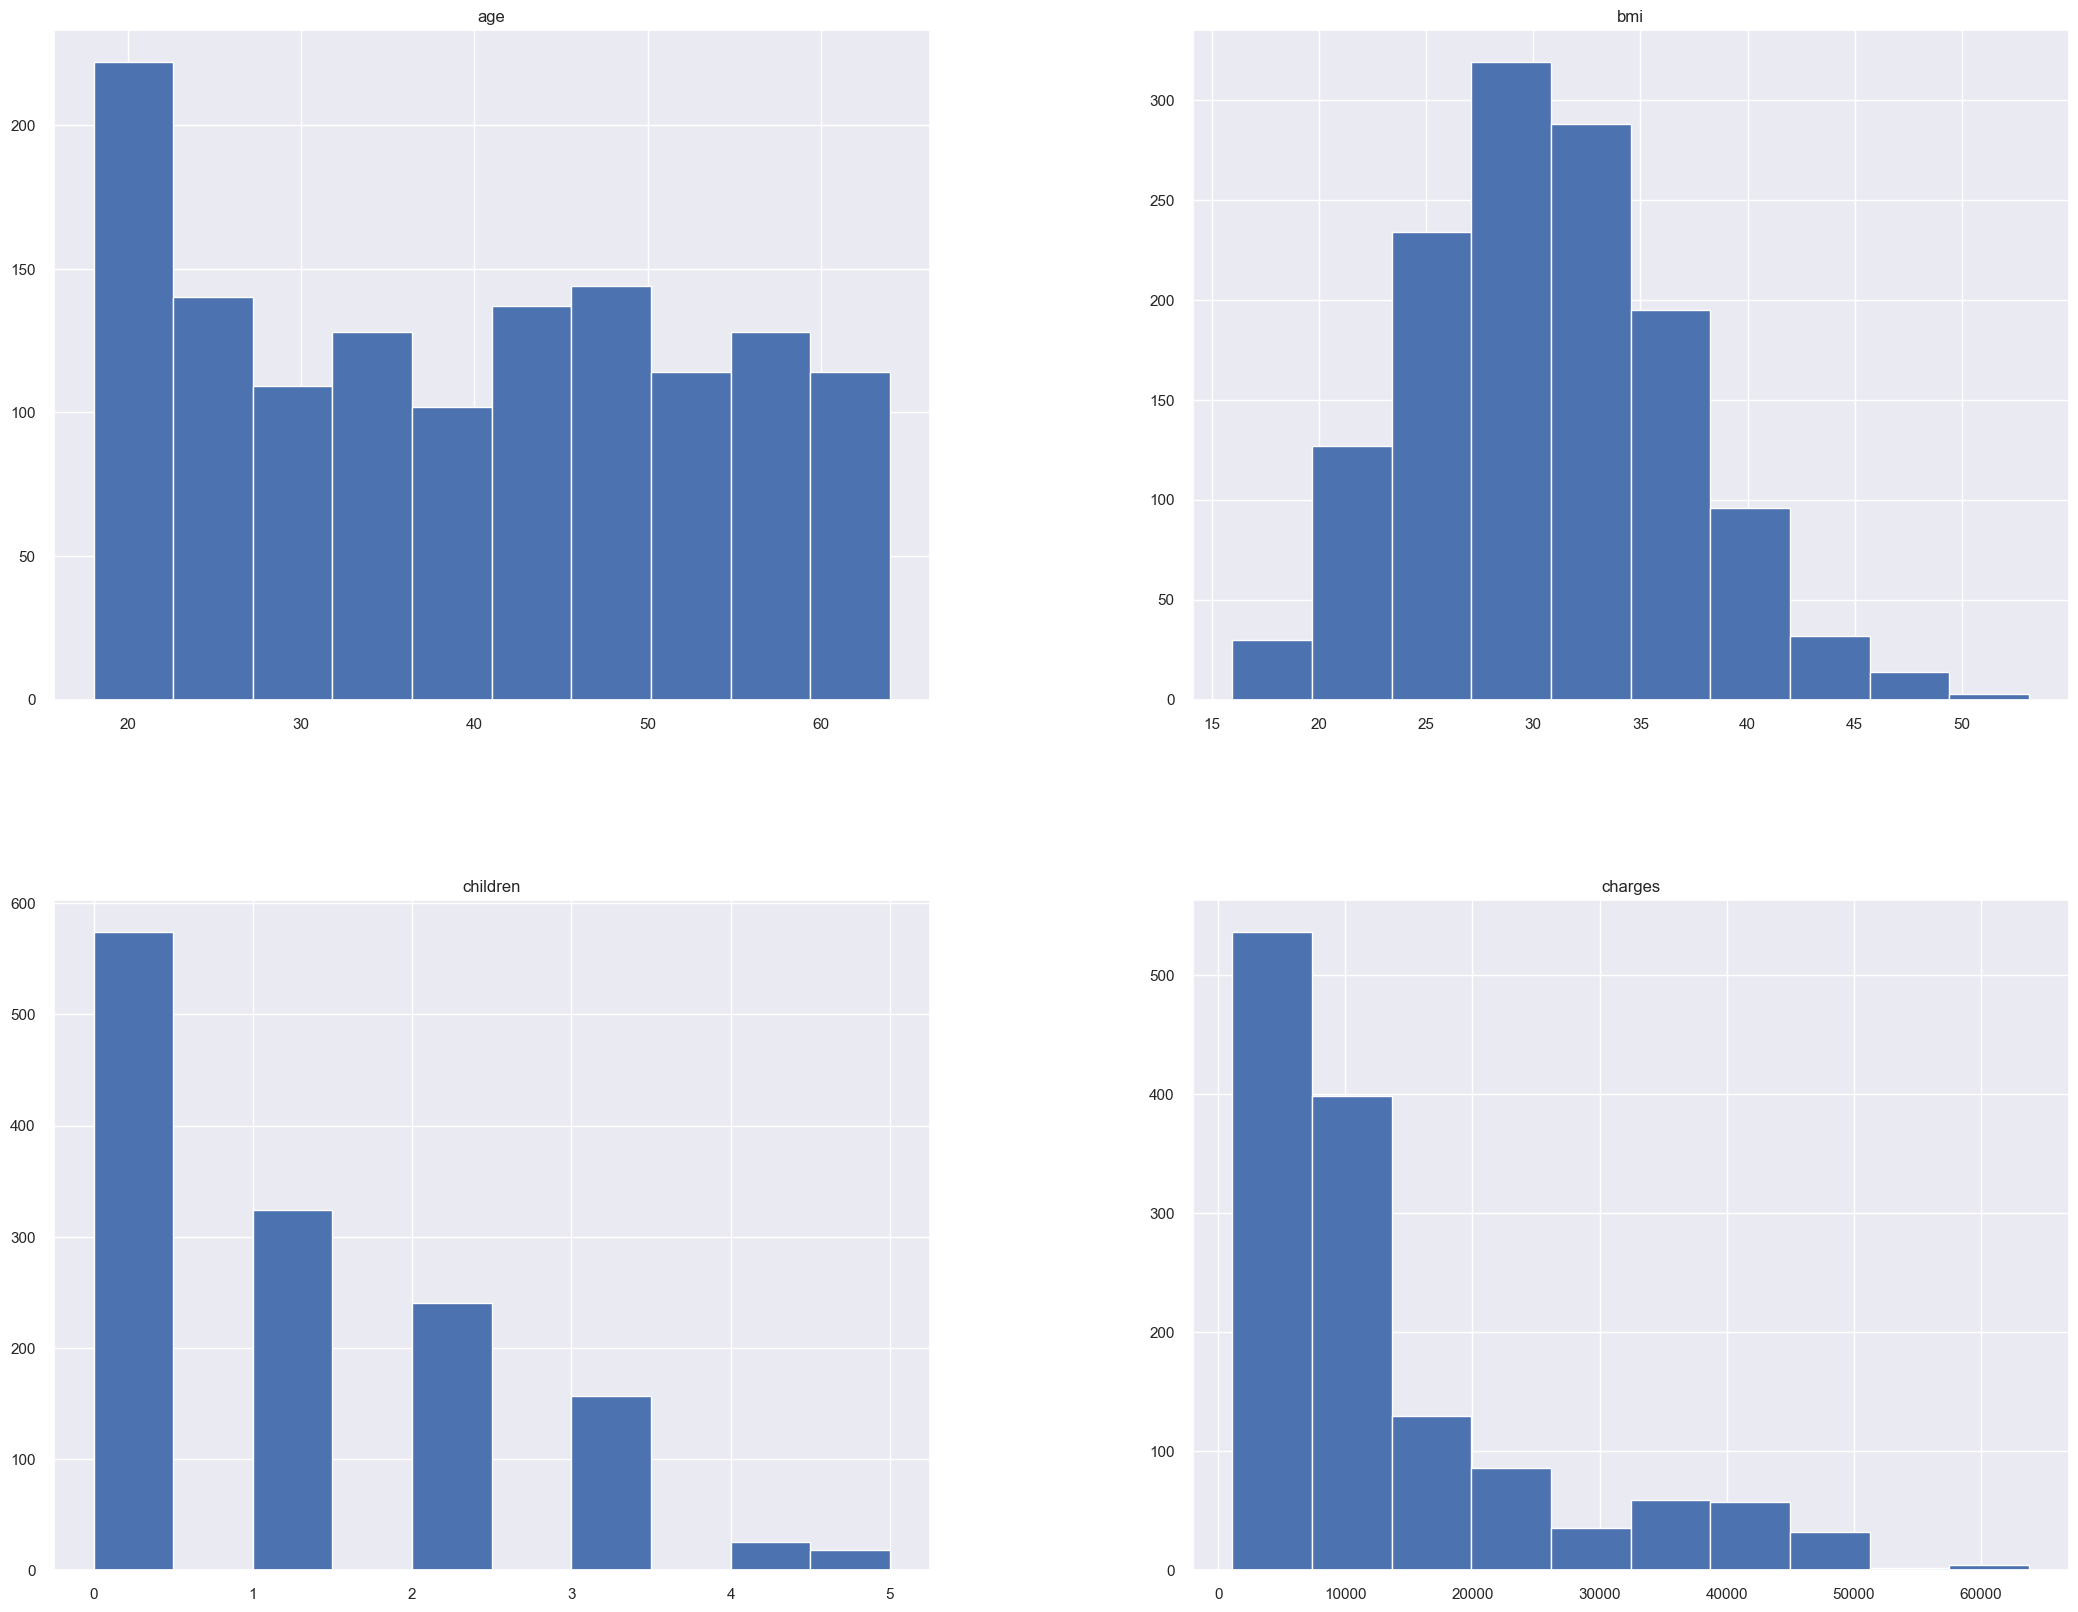

In [74]:
life_expectancy_data.hist(figsize=(26,20));

## Valores perdidos

Ahora que sabemos cómo se ven nuestros datos, es una buena idea verificar cuántos valores perdidos tenemos en cada variable.

In [75]:
life_expectancy_data.shape

(1338, 7)

In [76]:
life_expectancy_data.isna().sum().sort_values(ascending=False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Podemos utilizar toda esta información para diseñar una metodología de preprocesamiento eficaz y elegir un modelo adecuado adaptado a nuestros datos. Para mostrar cuán importante es esto, haremos dos preprocesamientos diferentes:

* **Preprocesamiento genérico**: simplemente transforma los datos en algo que un modelo puede procesar sin dar errores. Ignorando por completo las peculiaridades del conjunto de datos.

* **Preprocesamiento Específico**: Preprocesamiento adaptado a los modelos que estaremos utilizando y las particularidades de los datos.



### Protocolo de muestreo y prueba

Usaremos dos particiones de datos (entrenamiento y prueba) con validación cruzada sobre la partición de entrenamiento para decidir los hiperparámetros. 

Explicaremos en detalle la validación cruzada en la sección 3.

In [78]:
X = life_expectancy_data.loc[:,life_expectancy_data.columns != 'charges']
y = life_expectancy_data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## SECCIÓN 3: Regresión lineal (con mínimo preprocesamiento de los datos)

Esta es la sesión de laboratorio de Regresión Lineal. Por esta razón, utilizaremos los modelos de regresión lineal, regresión LASSO y regresión RIDGE. Estos modelos no son compatibles con valores faltantes, ni variables categóricas. Por lo tanto, lo mínimo absoluto que debemos hacer con nuestros datos es eliminar muestras con faltantes y variables categóricas.

In [79]:
def minimum_preprocessing(X, y):
    print('Tamaño original:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    # Eliminamos variables categoricas
    X=X.drop(columns=categorical_columns)
    print('Eliminadas: {}'.format(categorical_columns))
    # Eliminamos valores perdidos
    X=X.dropna()
    y=y[X.index]
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

Aplicaremos por separado nuestro preprocesamiento a nuestras particiones de entrenamiento y prueba para evitar generar sesgos en nuestros datos.

In [80]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Tamaño original:(896, 6)
Eliminadas: ['sex' 'smoker' 'region']
Nuevo tamaño:(896, 3)
Tamaño original:(442, 6)
Eliminadas: ['sex' 'smoker' 'region']
Nuevo tamaño:(442, 3)


### Regresión lineal

Pequeño recordatorio de como funciona la regresión lineal: 

Modelamos nuestra función de regresión como

 $y = f(x) + \epsilon = w^\top x + \epsilon$
 
 dónde:
 * $y$ es nuestro objetivo.
 * $w$ son los pesos que calcularemos.
 * $x$ son nuestras muestras.
 * $\epsilon$ es el ruido de las muestras.

Si asumimos que el ruido es gaussiano, resolver este problema equivale a minimizar el error cuadrático medio de esta función.

$\min_w || y-Xw ||^2$

Veremos dos implementaciones diferentes de regresión lineal. La de statsmodels y la de scikit-learn.


#### Scikit-learn linear regression

Los modelos scikit-klearn son realmente fáciles de usar. Todos están implementados en clases con la misma estructura, por lo que al conocer uno, se conocen todos.

In [81]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);

In [82]:

weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [226.86576343 318.66337616 668.7930722 ]
Interceptor: 
 -5989.286223757974



#### Statsmodels linear regression
*La regresión lineal de Statsmodels* es un poco más difícil de usar pero genera una gran cantidad de datos estadísticos que pueden ser útiles.

In [83]:
# Linear regression se llama ordinary least squares (OLS) en statsmodels
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     37.36
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           9.59e-23
Time:                        04:49:44   Log-Likelihood:                -9641.9
No. Observations:                 896   AIC:                         1.929e+04
Df Residuals:                     892   BIC:                         1.931e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5989.2862   2180.955     -2.746      0.006   -1.03e+04   -1708.885
age          226.8658     27.117      8.366      0.000     173.645     280.086
bmi          318.6634     64.251      4.960      0.000     192.562     444.764
children     668.7931    317.864      2.104      0.036      44.944    1292.642
==============================================================================
Omnibus:                      226.884   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.805
Skew:                           1.541   Prob(JB):                     3.45e-93
Kurtosis:                       4.382   Cond. No.                         293.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretando esta salida:

Cada muestra individual será una matriz con la siguiente estructura:

$x=(1, adult\_mortality, infant\_deaths,\dots, schooling)^T$

Los pesos del modelo después del entrenamiento son:

$w=(53.8131, -0.017, 0.1059, \dots,0.9182)^T$

Y el modelo:

$y(x; w) = w^T x = 53.8131 - 0.017*adult\_mortality + 0.1059*infant\_deaths + \dots + 0.9182*schooling$

Además de los pesos, statsmodels devuelve el intervalo de confianza del 95 % de estos pesos ([0,025 0,975]), el error estándar de los pesos (std err) y el valor p (P>|z|). Si el valor de p es menor a un umbral (generalmente 0.05), podemos decir que la variable es relevante para predecir el objetivo.

Los residuos (la diferencia entre el valor objetivo real y el valor objetivo previsto) son:

 $(t_n - y(x_n; w)), n = 1,\dots N$

Si representamos los residuos de los datos de entrenamiento obtenemos la siguiente distribución:



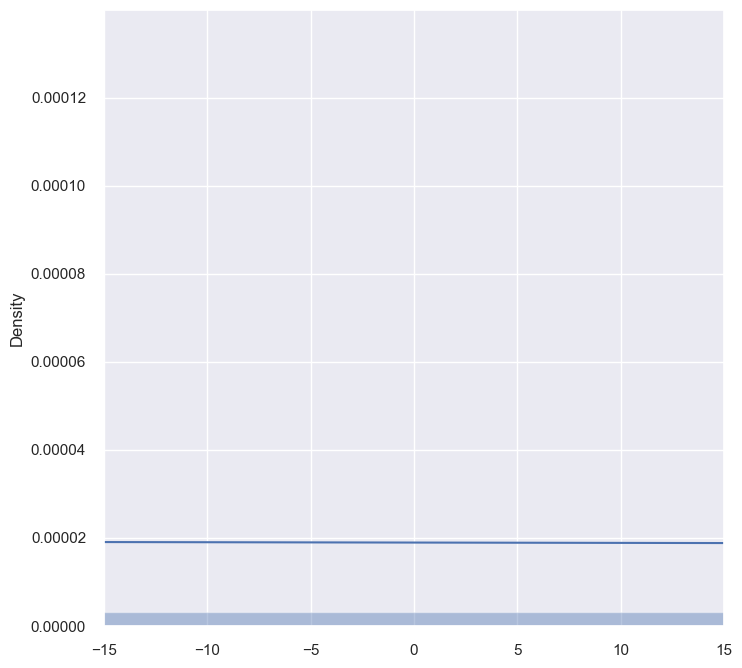

In [84]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-15,15])
sns.distplot(result.resid,bins=30);

Esperamos que este gráfico parezca gaussiano, ya que es nuestra suposición inicial (error gaussiano). Por esta razón, esta gráfica es un indicador directo de la validez del modelo.

Otra gráfica que podemos usar para validar nuestro modelo es un QQ-plot.

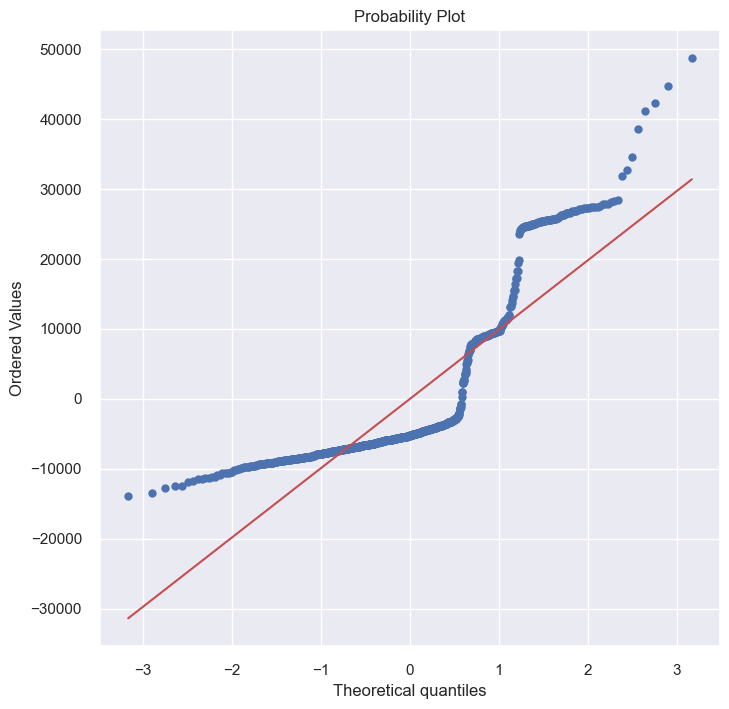

In [85]:
fig, ax = plt.subplots(figsize=(8,8))
stats.probplot(result.resid, plot=plt);

Podemos obtener un gráfico de los residuos del entrenamiento y el test con el _qqplot_ o el _histograma_ con la librería `yellowbrick`

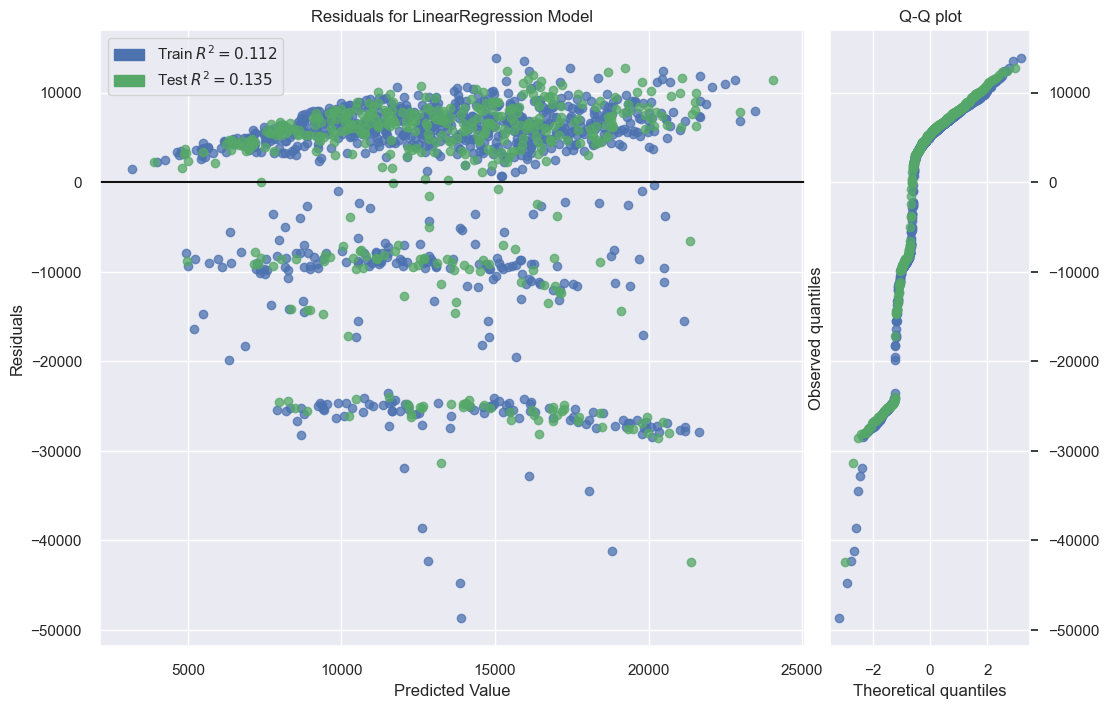

In [86]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

También podemos representar las predicciones respecto a los valores reales y ver cuanto se desvían de la predicción ideal

<Figure size 800x800 with 0 Axes>

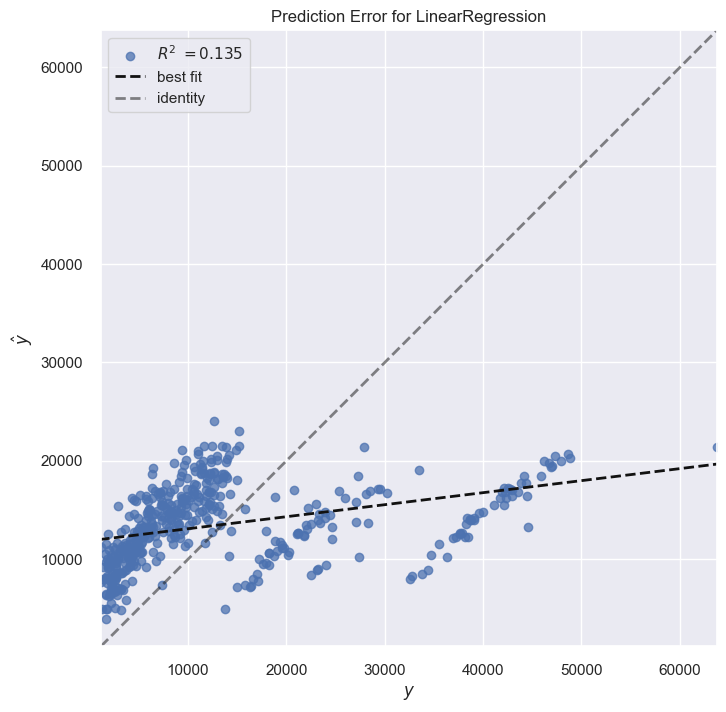

In [87]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)

## SECCIÓN 3: Metricas

Hay métricas alternativas que podemos usar para medir el rendimiento de un modelo de regresión.
Repasaremos las más comunes sobre las predicciones de datos de entrenamiento.

**Mean Squared Error (MSE)** 

El mejor resultado posible sería un MSE de 0, lo que significaría una predicción perfecta.

$MSE(t,y) = \frac{1}{N} \sum_{i=1}^N (t - y(x;w))^2$

In [88]:
N = X_train.shape[0]

# usando statsmodel
prediction = result.predict(sm.add_constant(X_train))
mean_square_error = np.sum((y_train - prediction)**2)/N

# También se puede calcular con su implementacion en scikit-learn
mean_square_error_sk = mean_squared_error(y_train, prediction)

mean_square_error, mean_square_error_sk

(130153665.5639037, 130153665.5639037)

Este número depende de la magnitud de la variable objetivo, por lo que no podemos saber si es bueno o malo directamente. Es una muy buena práctica normalizarlo dividiendo por la varianza no sesgada de la muestra de la variable objetivo. De esta manera obtenemos el

**Normalized Mean Squared Error**

Nuevamente, el mejor resultado posible sería 0, por la misma razón.

$norm\_MSE(t,y) = \frac {MSE(t,y)}{\sigma^2(t)} $


In [89]:
norm_mse = np.sum((y_train - prediction)**2)/((N)*np.var(y_train))

# Se puede usar la implementacion de R^2 de para calcular este valor
norm_mse_sk = 1-r2_score(y_train,prediction)

norm_mse, norm_mse_sk

(0.8883864017868939, 0.8883864017868939)

Si dividimos el error cuadrático medio por la varianza de los objetivos t,
 obtenemos la proporción de la variabilidad del objetivo que NO es explicada por el modelo

 Un modelo con 'norm.mse' igual a 1 es tan bueno como el mejor modelo constante
 (es decir, el modelo que siempre da como respuesta el promedio del objetivo)

 los modelos con 'norm.mse' por encima de 0.5 son regulares, mas alla de 0.7 empiezan a ser bastante malos

 los modelos con 'norm.mse' por debajo de 0.2 son bastante buenos


**R-squared (R^2)**

El R^2 (generalmente utilizado por los estadísticos) se obtiene restando esta cantidad de uno; es decir, la proporción de la variabilidad objetivo que explica el modelo; en este caso alcanza ~80%

Esta métrica suele mostrarse entre 0 y 1 o en porcentaje, pero hay que tener en cuenta que no esta limitada por abajo, una regresión puede ser arbitrariamente mala (valores negativos).

In [90]:
R_squared = (1 - norm_mse)

# También se puede usar la implementacion de scikit-learn
R_squared_sk = r2_score(y_train,prediction) 

R_squared, R_squared_sk

(0.11161359821310612, 0.11161359821310612)

**Mean Absolute Error (MAE)**

El mejor resultado posible también sería un MAE de 0, lo que significaría una predicción perfecta.

$MAE(t,y) = \frac{1}{N} \sum_{i=1}^N |t - y(x;w)|$

In [91]:
mae =  np.sum(np.abs(y_train - prediction))/N

# Se puede usar la implementacion de MAE de para calcular este valor
mae_sk = mean_absolute_error(y_train,prediction)

mae, mae_sk

(9076.594938568913, 9076.594938568913)

Hemos visto aquí que el modelo tiene buenos resultados con los datos de entrenamiento, pero eso no significa que nuestro modelo sea un buen predictor.
Para tener una valoración numérica de su capacidad predictiva tenemos varias opciones:
* Obtenga nuevos datos (¡no es posible aquí!)
* Utilizar LOOCV.
* Predecir sobre una partición de validación específica y calcular las medidas pertinentes.
* Utilizar la validación cruzada.

No hemos guardado una partición específica para obtener métricas de validación y tenemos demasiadas muestras (1123 en proceso) para hacer LOOCV rápido. Por esta razón haremos validación cruzada.



## SECCIÓN 4: Validación cruzada (Cross Validation)

Necesitamos saber qué tan bueno es nuestro modelo. No podemos usar el conjunto de datos de entrenamiento para esto porque podría dar resultados artificialmente buenos. No podemos usar la partición de prueba porque necesitaremos comparar estos resultados con los obtenidos en otros modelos. Queremos usar el conjunto de prueba solo al final, para que pueda simular la ejecución del modelo con datos nuevos. De esta manera podemos obtener un error de generalización lo más cercano posible al error que obtendríamos usando el modelo con datos completamente nuevos.

Como no podemos usar ni el entrenamiento ni el conjunto de prueba para evaluar el modelo, usaremos **Validación cruzada** para calcular nuestras métricas, usaremos estas métricas comparar modelos y tomar cualquier decisión de diseño.


![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


In [92]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]));
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 144141851.023 NMSE: 0.871 R2: 0.129
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 144288342.332 NMSE: 0.889 R2: 0.111
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 113070472.273 NMSE: 1.011 R2: -0.011
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 129586897.535 NMSE: 0.912 R2: 0.088
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 126872314.879 NMSE: 0.853 R2: 0.147


In [93]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,144141851.023,0.871,0.129
Fold 2,144288342.332,0.889,0.111
Fold 3,113070472.273,1.011,-0.011
Fold 4,129586897.535,0.912,0.088
Fold 5,126872314.879,0.853,0.147
Mean,131591975.608,0.907,0.093


Usaremos la media de las particiones como nuestra métrica. También podemos hacer esto usando el método sklearn `cros_val_score`.

In [94]:
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([ 0.12944482,  0.110853  , -0.01104709,  0.08824603,  0.14708193]),
 0.09291573790717764)

## SECCIÓN 5: Regresión lineal regularizada: Ridge and LASSO

Ahora que tenemos una forma de evaluar el rendimiento de nuestro modelo, veamos si mejora agregando regularización. 

### Ridge Regression

Esta vez vamos a minimizar la siguiente función:

$\min_w (|| y - Xw ||^2 + \lambda \cdot ||w||^2_2)$

El último término penaliza que los pesos sean demasiado grandes (en magnitud).
El hiperparámetro $\lambda$ controlará cuánto los estamos penalizando.

Lambda no se calcula sobre el proceso de entrenamiento como los pesos, es un *hiperparámetro*.
Entonces ahora la pregunta es: ¿Cómo podemos encontrar la mejor $\lambda$ para nuestro conjunto de datos?

Hemos dicho en la sección anterior que podemos usar métricas de validación cruzada para comparar el rendimiento predictivo de diferentes modelos. Podemos hacer lo mismo para comparar el mismo modelo con diferentes hiperparámetros.

In [95]:
ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
# Calculamos las metricas de validación cruzada para cada lambda
for lambda_val in lambdas:
    kf = KFold(n_splits=5)
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    # Calculamos la metrica para cada particion y hacemos la media
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        lr = Ridge(alpha=lambda_val).fit(x_train_fold,y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    ridge_cross_val_metrics.loc[f'Lambda={lambda_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)

,mean MSE,mean norm_MSE,mean R2
Lambda=100,131577436.242,0.907,0.093
Lambda=50,131583220.175,0.907,0.093
Lambda=10,131589948.596,0.907,0.093
Lambda=5,131590943.502,0.907,0.093
Lambda=1,131591766.165,0.907,0.093
Lambda=0.5,131591870.696,0.907,0.093
Lambda=0.1,131591954.596,0.907,0.093
Lambda=0.01,131591973.507,0.907,0.093
Lambda=0.001,131591975.398,0.907,0.093
Lambda=0.0001,131591975.587,0.907,0.093


In [96]:
lr.coef_

array([220.3328306 , 289.59783024, 477.83032519])

Otra manera es usar la implementacion de scikit-learn

In [97]:
ridge_cv =RidgeCV(alphas=lambdas,cv=5).fit(X_train,y_train)

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 100.0 R2 score: 0.093


Podemos obtener una visualización usando el método AlphaSelection de `yellowbrick`

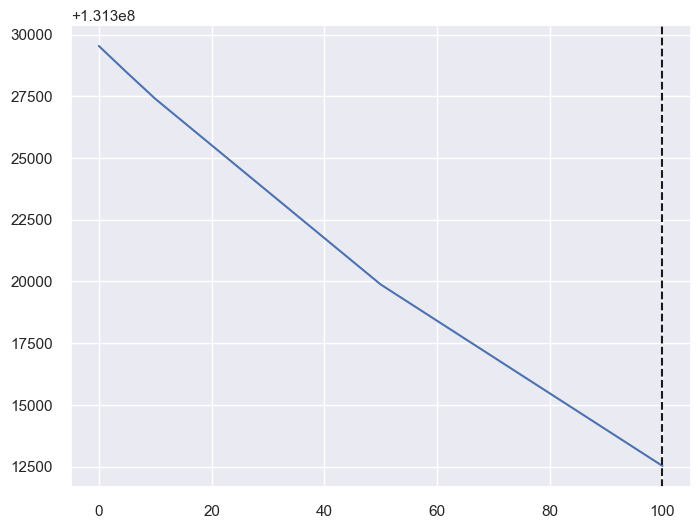

In [98]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(RidgeCV(alphas=lambdas));
vis.fit(X_train, y_train);

Ridge Regression no parece mejorar los resultados de la regresión lineal. Comprobemos si LASSO funciona mejor.

### Regresión LASSO

Esta vez penalizamos los pesos usando su norma L1.


$\min_w (|| y - Xw ||^2 + \lambda * |w|)$

Usaremos el método CV de scikit-learn para calcular la mejor $\lambda$ directamente.



In [99]:
lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 50.0 R2 score: 0.09283299497746847


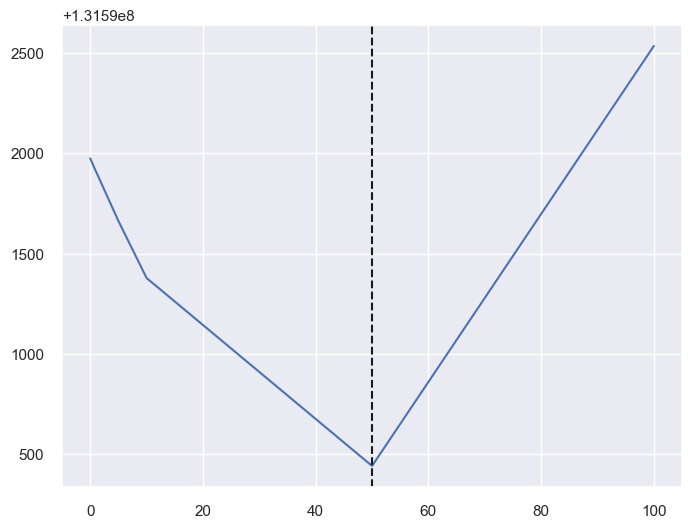

In [100]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

In [101]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.093,0.093,0.093
Train R2,0.111,0.112,0.112
lambda,0.000,100.000,50.000


## SECCIÓN 6: Entender los modelos es importante &#x261d;

Tampoco podemos ver una gran mejora con LASSO.

Entonces, ¿por qué la regularización no funciona cuando se supone que debe dar mejores modelos?

Comprobemos los pesos de nuestros tres modelos.

In [102]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train.columns)
weights.T

,age,bmi,children
lr,220.333,289.598,477.830
ridge_cv,227.067,317.613,620.873
lasso_cv,226.883,317.256,634.316


Visualmente:

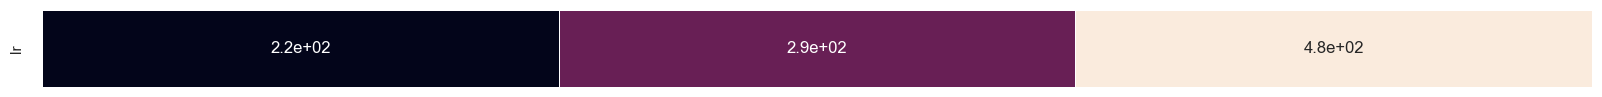

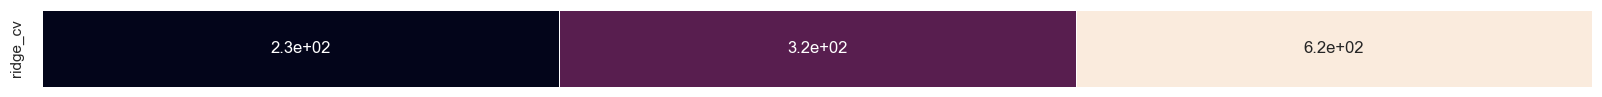

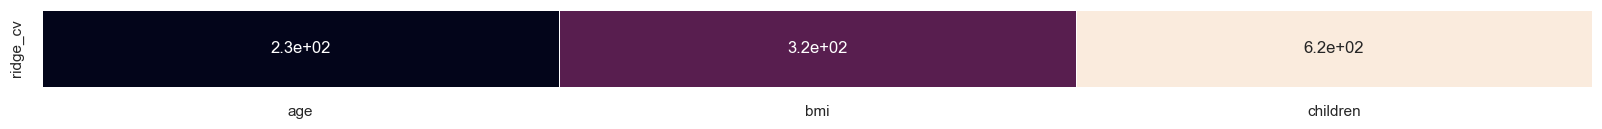

In [103]:
fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Podemos ver algunos patrones extraños en nuestros pesos, en los tres modelos podemos ver una amplia gama de valores. Tanto LASSO como Ridge tienen casi el mismo peso.

Si comparamos los pesos con los valores medios de nuestras variables, podemos ver que la regresión lineal está tratando de equilibrar los rangos de las variables. Probablemente por eso nuestros modelos regularizados no funcionan tan bien.

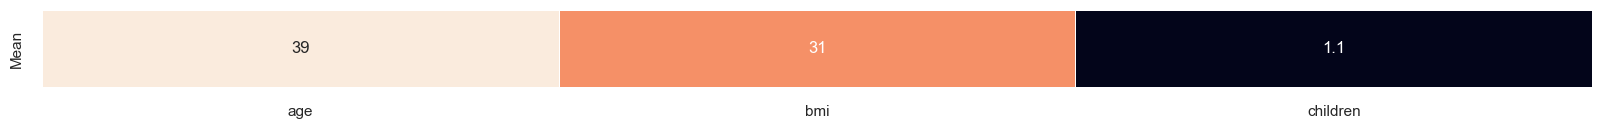

In [104]:
plt.figure(figsize = (20,1));
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Vamos a arreglar esto escalando nuestros datos. De esta forma, todas las variables tendrán el mismo rango y aprovecharemos mejor nuestros modelos.

**Tened en cuenta que la forma de hacer el procesamiento previo para los datos del test se obtiene del que hemos hecho a los datos de entrenamiento. Esencialmente, esto es para evitar cualquier tipo de sesgo entre entrenamiento y test**

In [105]:
def scaling_preprocessing(X, y, scaler=None):
    print('Tamaño Original:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    
    # Escalamos las variables numericas
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    if scaler is None: 
        # Generamos el scaler cuando los datos son los de entrenamiento
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # Eliminamos las variables categoricas
    X=X.drop(columns=categorical_columns)
    print('Eliminadas: {}'.format(categorical_columns))
    # Eliminamos los valores perdidos
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train, scaler = scaling_preprocessing(X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(X_test,y_test,scaler)

Tamaño Original:(896, 6)
Eliminadas: ['sex' 'smoker' 'region']
New shape:(896, 3)
Tamaño Original:(442, 6)
Eliminadas: ['sex' 'smoker' 'region']
New shape:(442, 3)


Ahora nuestras variables tienen rangos más razonables. Veamos cómo afecta esto a los pesos y el rendimiento de nuestro modelo.

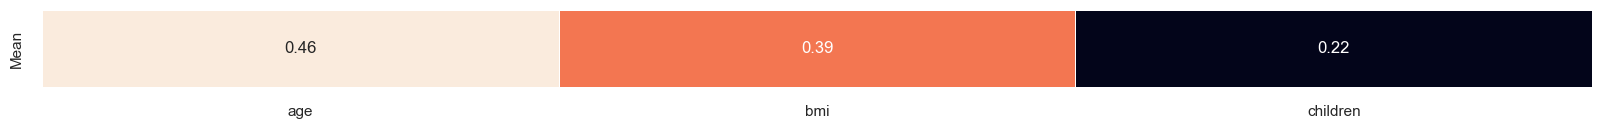

In [106]:
plt.figure(figsize = (20,1));
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}),annot=True, linewidths=.5,cbar=False,xticklabels=True);

In [107]:
lr_scaled = LinearRegression().fit(X_train,y_train)
r2_lr_scaled = np.mean(cross_val_score(lr_scaled, X_train,y_train, cv=5, scoring='r2'))

ridge_cv_scaled =RidgeCV(alphas=lambdas,cv=5).fit(X_train,y_train)
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train,y_train, cv=5, scoring='r2'))


lasso_cv_scaled =LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)
r2_lasso_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train,y_train, cv=5, scoring='r2'))

weights = pd.DataFrame({'lr scaled':lr_scaled.coef_, 'ridge_cv scaled':ridge_cv_scaled.coef_, 'lasso_cv scaled':lasso_cv_scaled.coef_},index=X_train.columns)
weights.T

,age,bmi,children
lr scaled,10435.825,11844.718,3343.965
ridge_cv scaled,9979.892,9822.198,3086.291
lasso_cv scaled,10360.799,11473.884,3178.084


In [108]:
r2_results = pd.DataFrame({'lr':r2_lr_scaled, 'ridge_cv':r2_ridge_scaled, 'lasso_cv':r2_lasso_scaled,},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr_scaled.predict(X_train)),
                                r2_score(y_train,ridge_cv_scaled.predict(X_train)),
                                r2_score(y_train,lasso_cv_scaled.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv_scaled.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv_scaled.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.093,0.091,0.091
Train R2,0.112,0.111,0.112
lambda,0.000,5.000,10.000


Los resultados no han mejorado mucho. Tal vez la inclusión de variables categóricas ayude.

Tenemos dos variables categóricas. País y estado.

In [109]:
def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns =X.dtypes[X.dtypes == 'category'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    # Escalamos las variables numericas
    if scaler is None: 
        # Generamos el scaler cuando los datos son los de entrenamiento
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # Aplicamos un one-hot encoding a las variables categoricas
    for column in categorical_columns:
        X_one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.merge(X_one_hot,left_index=True,right_index=True)
        X = X.drop(columns=[column])
    
    # Eliminamos los valores perdidos
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(896, 6)
New shape:(896, 11)
Original shape:(442, 6)
New shape:(442, 11)


Si usamos este nuevo preprocesamiento obtenemos muy buenos resultados en el conjunto de entrenamiento pero muy malos resultados en la validación cruzada.

Esto significa que nuestro modelo no podrá generalizarse si tratamos de usarlo en datos nuevos.

¿Cómo puede ser que teniendo más información nuestro modelo esté funcionando peor?

In [110]:
lr_one_hot = LinearRegression().fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=5, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

Train R2 score: 0.7456067465057508
Cross-Validation R2 score: 0.729742674129352


Tenemos dos problemas con nuestro modelo:
1. Está **sobreajustando** los datos de entrenamiento. Entonces, cuando recibe nuevos datos que no se han utilizado en el entrenamiento, no puede predecir.
2. Esto podría deberse a la **maldición de la dimensionalidad**. Tenemos 214 variables para 1123 muestras, que no es una gran proporción.

También podemos ver en los pesos de nuestro modelo que algo falla, ya que hay diferencias entre los rangos de peso.

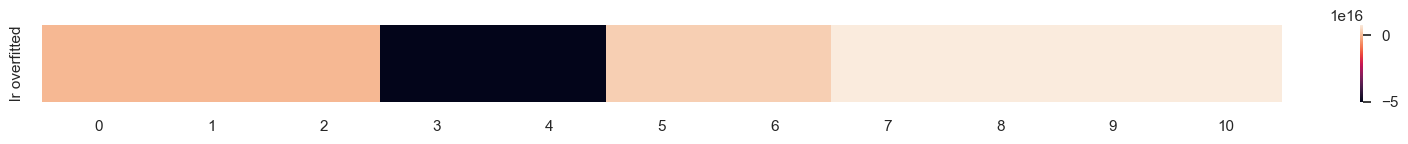

In [111]:
plt.figure(figsize = (20,1));
sns.heatmap(pd.DataFrame({'lr overfitted':lr_one_hot.coef_}).T);

Finalmente, si comprobamos cómo se ven nuestros datos, veremos que tenemos una matriz muy dispersa. Entonces, además de todos nuestros problemas, estamos tratando de usar SVD en una matriz dispersa, lo cual no es lo ideal.

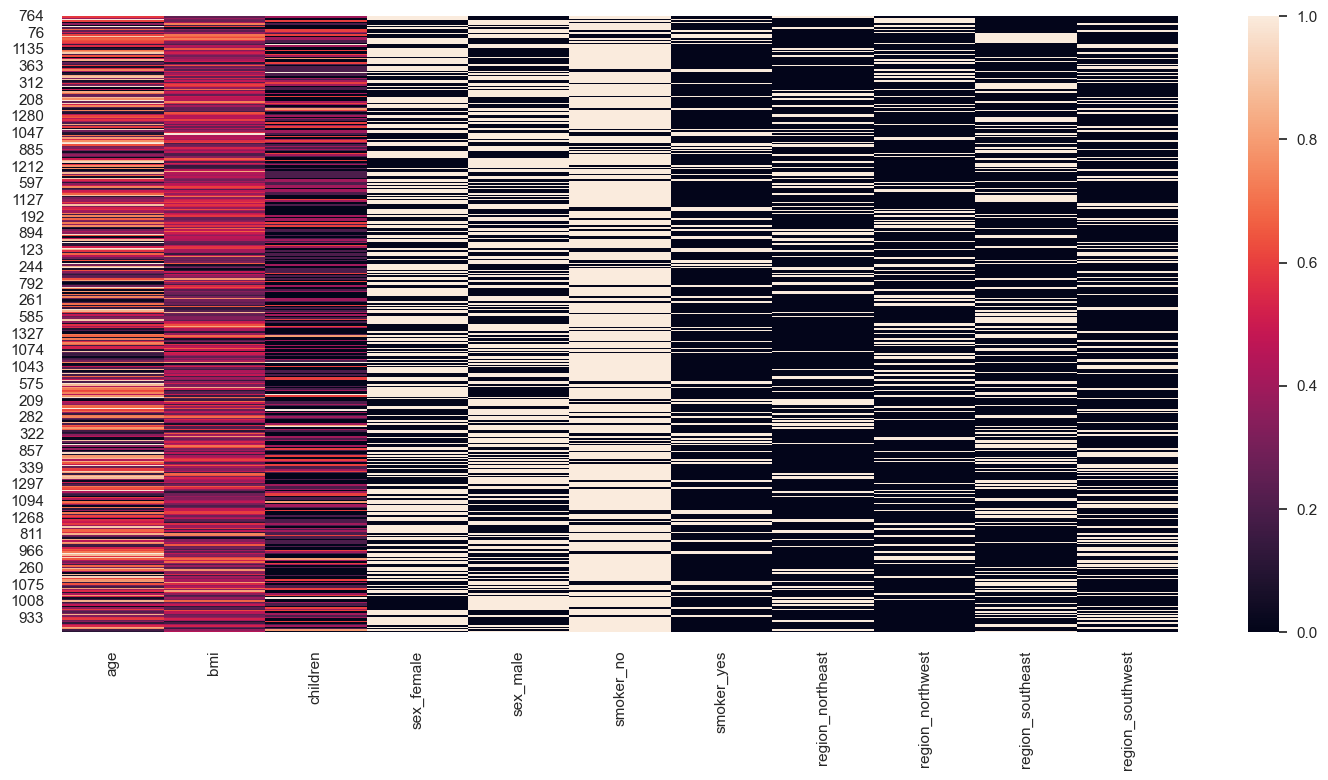

In [112]:
plt.figure(figsize=(18,8));
sns.heatmap(X_test);

Para corregir el sobreajuste, podemos eliminar esta variable o aplicar la regularización. Veamos cómo se comportan nuestros modelos regularizados.

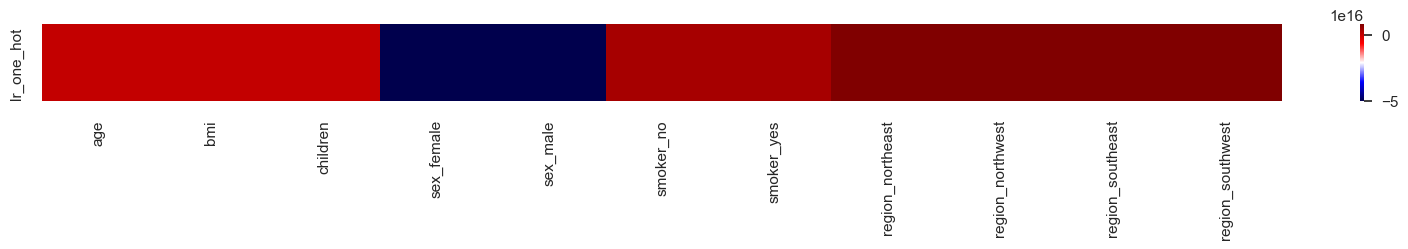

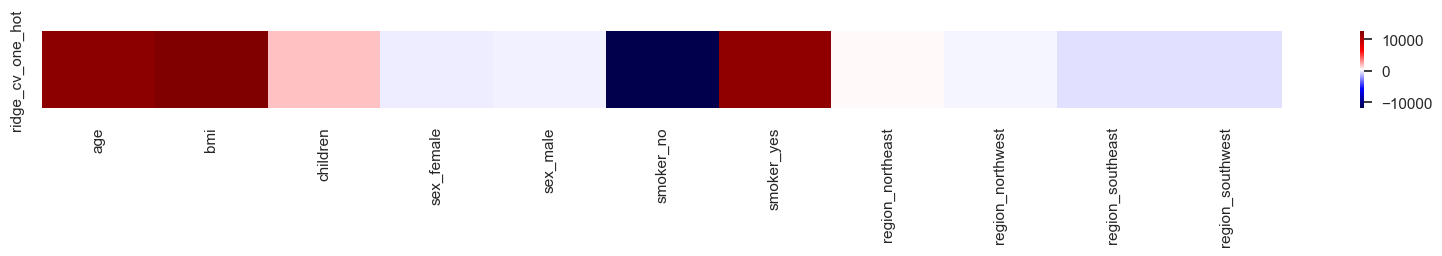

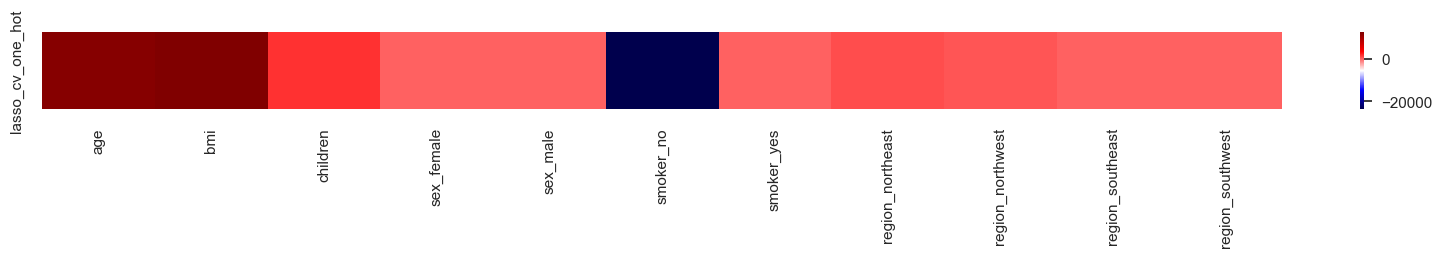

In [113]:
ridge_cv_one_hot = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)

r2_ridge_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

lasso_cv_one_hot = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)

r2_lasso_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

weights = pd.DataFrame(
    {
        'lr_one_hot': lr_one_hot.coef_,
        'ridge_cv_one_hot': ridge_cv_one_hot.coef_,
        'lasso_cv_one_hot': lasso_cv_one_hot.coef_
    },
    index=X_train.columns)

for column in weights.columns:
    fig= plt.figure(figsize=(20,1))
    ax=sns.heatmap(weights[[column]].T, cmap="seismic")

Obtenemos menores pesos en nuestros modelos regularizados. ¿Afectará esto al rendimiento de nuestros modelos?

In [114]:
r2_results.loc[:, 'lr_one_hot'] =[r2_lr_one_hot_cv, r2_lr_one_hot_train, 0]
r2_results.loc[:, 'ridge_cv_one_hot'] =[r2_ridge_one_hot_cv, r2_ridge_one_hot_train, ridge_cv_one_hot.alpha_]
r2_results.loc[:, 'lasso_cv_one_hot'] =[r2_lasso_one_hot_cv, r2_lasso_one_hot_train, lasso_cv_one_hot.alpha_]
r2_results

,lr,ridge_cv,lasso_cv,lr_one_hot,ridge_cv_one_hot,lasso_cv_one_hot
CV R2,0.093,0.091,0.091,0.730,0.729,0.730
Train R2,0.112,0.111,0.112,0.746,0.746,0.746
lambda,0.000,5.000,10.000,0.000,0.500,10.000


Podemos ver en nuestras métricas de cv que la regularización mejora el rendimiento **mucho**. De esta forma, el modelo puede aprovechar los datos adicionales que le proporcionamos y controlar eficazmente el sobreajuste.

## SECCIÓN 7: Selección del modelo

Ahora usamos el R^2  para elegir el mejor modelo, obtendremos para el conjunto de test esta medida. Según nuestras métricas de validación, el mejor modelo es ridge_cv con una lambda de 0,001 utilizada con el conjunto de datos estandarizados con variables categóricas.

Ahora que hemos tomado todas las decisiones relacionadas con nuestro modelo y el preprocesamiento de datos. Usamos el conjunto de prueba para ver cómo se generaliza el modelo. Se supone que este paso simula cómo funciona el modelo con datos *completamente nuevos*, es decir, datos que nunca antes había visto.

**Normalmente, antes de probar el "método ganador" lo voleríamos a ajustar con todos los datos de entrenamiento; el método RidgeCV hace esto de forma predeterminada para nosotros, por lo que no es necesario que lo hagamos aquí.**

Es importante usar el conjunto de test solo para dar el rendimiento final, de lo contrario corremos el riesgo de dar un resultado demasiado optimista.

In [115]:
y_tes_predicted = ridge_cv_one_hot.predict(X_test)
r2_ridge = ridge_cv_one_hot.score(X_test,y_test)

print('Mean sqared error with test data: {}'.format(mean_squared_error(y_test,y_tes_predicted)))
print('R2 score with test data: {}'.format(r2_ridge))

Mean sqared error with test data: 35079529.36459751
R2 score with test data: 0.7606222543814287


<Figure size 800x800 with 0 Axes>

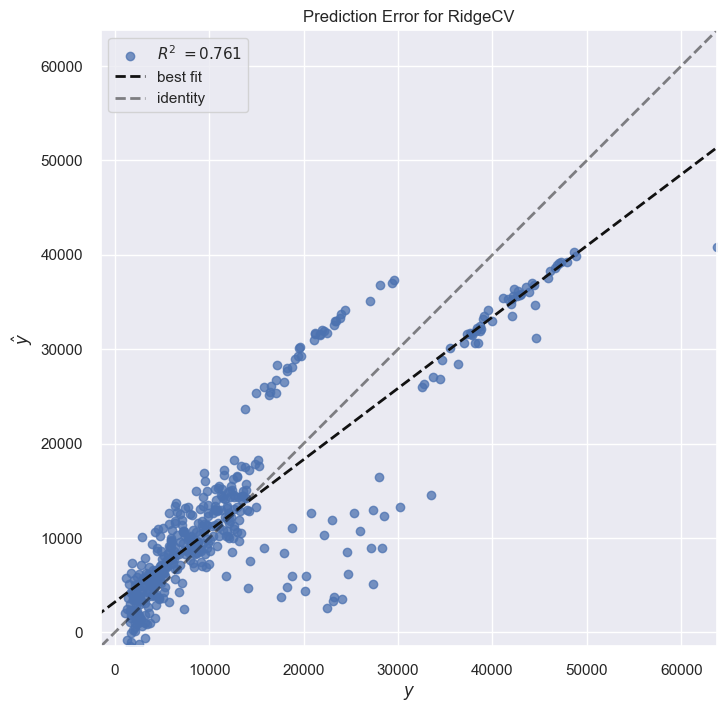

In [116]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(ridge_cv_one_hot, X_test, y_test, is_fitted=True)

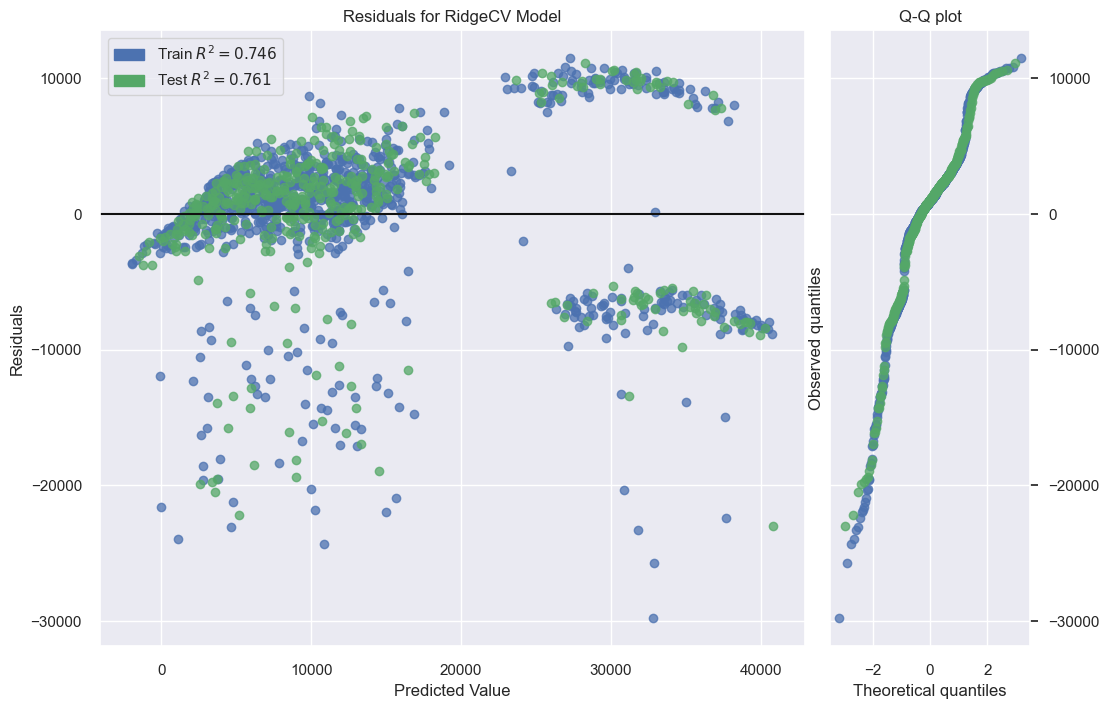

In [117]:
plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_cv_one_hot, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [118]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:04:16.486661
